### MNIST 손글씨 - CNN v3
- 2 x Conv2D layers
- 1 x MaxPooling2D layer
- 1 Dropout(0.25) layer
- 1 FCN layer
- 1 Dropout(0.5) layer
- 1 Output layer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
tf.__version__

'2.14.0'

- 데이터 전처리

In [3]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# X data의 차원 변경 및 정규화(0 ~ 1)
X_train = X_train.reshape(-1, 28, 28, 1) / 255.
X_test = X_test.reshape(-1, 28, 28, 1) / 255.

In [5]:
# y_data의 one-hot-encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

- 모델 정의/설정/학습/평가

In [6]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
model = Sequential([
    Conv2D(32, kernel_size=(3,3), input_shape=(28, 28, 1), activation='relu'),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),         # MaxPooling2D(pool_size=(2,2))
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4719104   
                                                        

- Param 320개? 3 * 3 (f00 ~ f22, weight) * 32(filter 수) + 32(bias) = 320
- Param 18496 : 32(처음 이미지 1 > 32개로) * 3 * 3 * 64 + 64 (위와 같음)

In [8]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [9]:
!mkdir models      # ! 리눅스 명령어
!ls -l

total 8
drwxr-xr-x 2 root root 4096 Nov  8 02:13 models
drwxr-xr-x 1 root root 4096 Nov  6 14:20 sample_data


In [10]:
model_path = 'models/best-mnist-v3.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

In [11]:
hist = model.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=100, batch_size=256, callbacks=[mc, es]
)

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9260
Epoch 1: val_loss improved from inf to 0.06064, saving model to models/best-mnist-v3.h5
188/188 [==============================] - 16s 24ms/step - loss: 0.2366 - accuracy: 0.9260 - val_loss: 0.0606 - val_accuracy: 0.9834
Epoch 2/100
  1/188 [..............................] - ETA: 3s - loss: 0.0797 - accuracy: 0.9648

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


185/188 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9790
Epoch 2: val_loss improved from 0.06064 to 0.04743, saving model to models/best-mnist-v3.h5
188/188 [==============================] - 3s 18ms/step - loss: 0.0671 - accuracy: 0.9790 - val_loss: 0.0474 - val_accuracy: 0.9862
Epoch 3/100
186/188 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9857
Epoch 3: val_loss improved from 0.04743 to 0.03981, saving model to models/best-mnist-v3.h5
188/188 [==============================] - 3s 18ms/step - loss: 0.0459 - accuracy: 0.9856 - val_loss: 0.0398 - val_accuracy: 0.9883
Epoch 4/100
187/188 [============================>.] - ETA: 0s - loss: 0.0353 - accuracy: 0.9891
Epoch 4: val_loss improved from 0.03981 to 0.03529, saving model to models/best-mnist-v3.h5
188/188 [==============================] - 4s 19ms/step - loss: 0.0352 - accuracy: 0.9891 - val_loss: 0.0353 - val_accuracy: 0.9897
Epoch 5/100
186/188 [============================

In [12]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0320 - accuracy: 0.9911


[0.03203532099723816, 0.991100013256073]

In [13]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

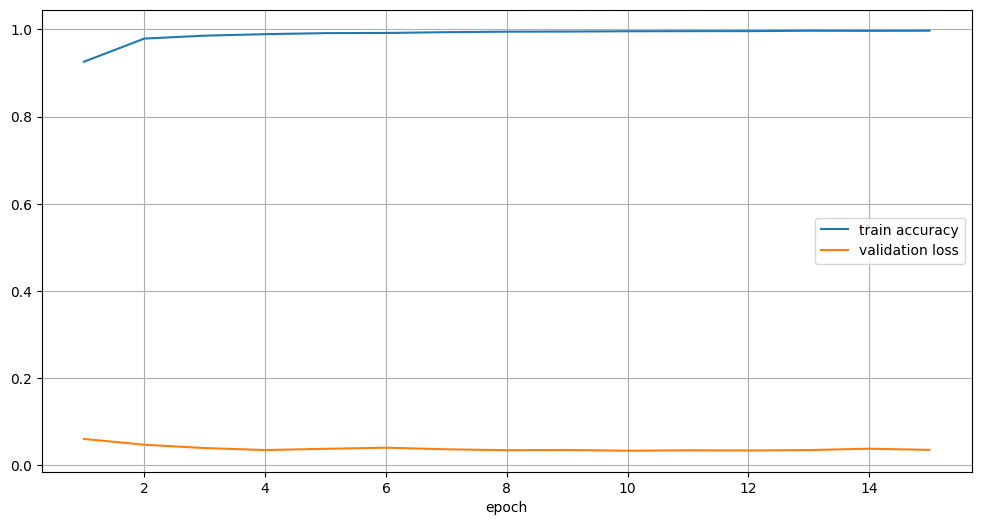

In [14]:
plt.figure(figsize=(12,6))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid(), plt.xlabel('epoch')
plt.title('MNIST CNN V3')
plt.show()